# Markov Chain Monte Carlo workshop

# Exercise 1: fitting an absorption line in a stellar spectrum with MCMC

We downloaded the spectrum of an O/B transition star from the *SDSS Spectral Cross-correlation Templates*:

http://www.sdss2.org/dr3/algorithms/spectemplates/index.html.

The following cells import the necessary packages and plot the data.

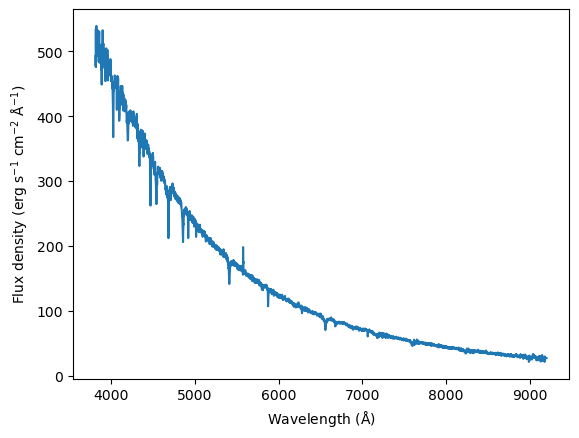

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee
import corner

# load the y-axis data
spectrum_flux = fits.open("data/spDR2-001.fit")[0].data[0]

# get the x-axis scale
coeff0, coeff1 = 3.5815, 0.0001  # logarithm of wavelength (in angstrom) and log(A/pix)
wavelengths = 10.0 ** (coeff0 + coeff1 * np.arange(len(spectrum_flux)))

plt.figure()
plt.plot(wavelengths, spectrum_flux)
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Flux density ($\mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$)")
plt.show()

## Cutting a window around the HeI absorption line

We zoom in a region around the wavelength of an absorption line corresponding to HeI.

*Use the `draw_model_parameters` to toggle on/off the model parameter visual aids...*

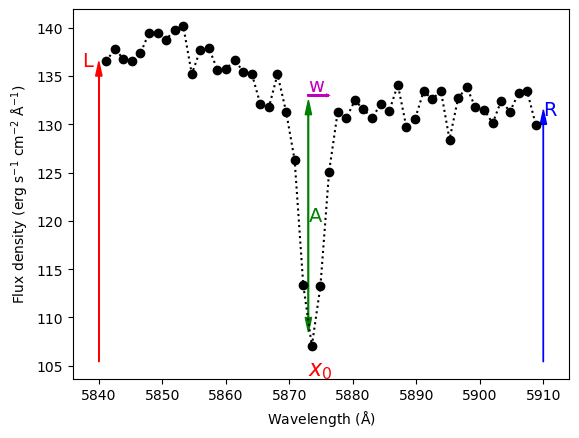

In [2]:
draw_model_parameters = True

# cut the window of interest...
He_min = 5840
He_max = 5910
window = (wavelengths > He_min) & (wavelengths < He_max)
x = wavelengths[window]
y = spectrum_flux[window]

# ...plot
plt.figure()
plt.plot(x, y, "ko:")
if draw_model_parameters:    
    x1, x2, y1, y2 = plt.axis()
    plt.arrow(5840, y1, 0, 135 - y1, color="r", head_width=1.0)
    plt.arrow(5910, y1, 0, 130 - y1, color="b", head_width=1.0)
    plt.arrow(5873, 110, 0, 131 - 110, color="g", head_width=1.0)
    plt.arrow(5873, 131, 0, 110 - 131, color="g", head_width=1.0)
    plt.arrow(5873, 133, 3, 0, color="m", linewidth=2)
    plt.text(5839, 136, "L", color="r", fontsize=14, ha="right")
    plt.text(5910, 131, "R", color="b", fontsize=14, ha="left")
    plt.text(5873, 120, "A", color="g", fontsize=14, ha="left")
    plt.text(5873, 133, "w", color="m", fontsize=14, va="bottom")
    plt.text(5873, 104, "$x_0$", color="r", fontsize=16)
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Flux density ($\mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$)")
plt.show()

##### Model for the underlying shape

$$\huge y_m(x) = \underbrace{ax + b}_\textrm{continuum} + A
  \underbrace {e^{-\frac{\left(x - x_0\right)^2}{2 w^2}}}_\textrm{absorption}$$

where the slope is computed from $L$ and $R$ and the $x$-axis positions they refer to: the minimum and maximum of $x_i$ respectively:

$$ \large a = \frac{R - L}{\max\left\{x_i\right\} - \min\left\{x_i\right\}}$$

Similarly, the intercept is given by:

$$ \large b = L - a \min\left\{x_i\right\} $$

##### Model for the observational data $(x_i, y_i)$

$$ \large y_i \sim \mathcal{N}\left(y_m(x_j), \sigma\right)$$

denoting that the data are normally distributed around the model with an **unknown** standard deviation $\sigma$.

## Part A: set the prior, likelihood and posterior functions

In [3]:
# set the names of the parameters (useful for reporting stuff...)
param_names = ["L", "R", "A", "x0", "w"]

xmin, xmax = min(x), max(x)    # used to convert L and R values to intercept and slope

# set minimum and maximum bounds for the parameters
min_L, max_L = 125.0, 145.0
min_R, max_R = 125.0, 145.0
min_A, max_A = -50.0, -10.0
min_x0, max_x0 = 5860, 5890
min_w, max_w = 0.5, 10.0

def model(theta, x):
    L, R, A, x0, w = theta
    a = (R - L) / (xmax - xmin)
    b = L - a * xmin
    return b + a * x + A * np.exp(-(x - x0) ** 2.0 / (2.0 * w ** 2.0))    # Gaussian
#     return b + a * x + A * 1.0 / (1.0 + ((x - x0) / w) ** 2.0)            # Lorentzian

def log_prior(theta):
    L, R, A, x0, w = theta
    if min_L < L < max_L and min_R < R < max_R and min_A < A < max_A and min_x0 < x0 < max_x0 and min_w < w < max_w:
        return 0.0
    return -np.inf
    
def log_likelihood(theta, x, y):
    return -np.sum((y - model(theta, x)) ** 2.0)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

## Part B: set the MCMC

Feel free to change the number of walkers and steps if you see poor convergence in the following parts of the exercise.

In [4]:
n_walkers = 30
n_dim = 5
n_steps = 1000

# random initial positions for walkers
L_initial = np.random.uniform(min_L, max_L, size=n_walkers)
R_initial = np.random.uniform(min_R, max_R, size=n_walkers)
A_initial = np.random.uniform(min_A, max_A, size=n_walkers)
x0_initial = np.random.uniform(min_x0, max_x0, size=n_walkers)
w_initial = np.random.uniform(min_w, max_w, size=n_walkers)

# code them in a matrix
p_initial = np.array([L_initial, R_initial, A_initial, x0_initial, w_initial]).T

## Part C: run the MCMC

In [5]:
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=log_posterior, args=(x, y))
result = sampler.run_mcmc(p_initial, nsteps=n_steps)

## Pard D: looking at the chains

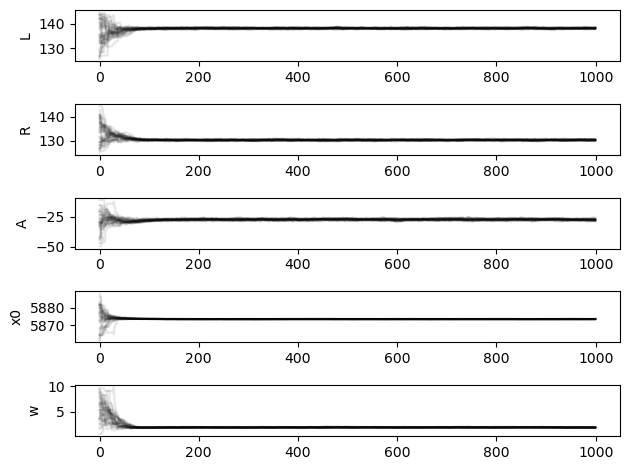

In [6]:
plt.figure()
# for each parameter...
for i in range(n_dim):
    param_name = param_names[i]
    plt.subplot(n_dim, 1, i + 1)
    # ...plot all chains
    for j in range(n_walkers):
        chain = sampler.chain[j, :, i]
        plt.plot(chain, "k-", alpha=0.1)
    plt.ylabel(param_name)
plt.tight_layout()
plt.show()

## Part E: burn in phase and corner plot

Select the number of steps of the burn in phse.

If the corner plot is too *noisy* use the `percentage_to_plot` to tell `corner` to avoid outliers. $1.0$ means it plots everything while $0.95$ means it will throw away $2.5\%$ of the lowest and higher values.

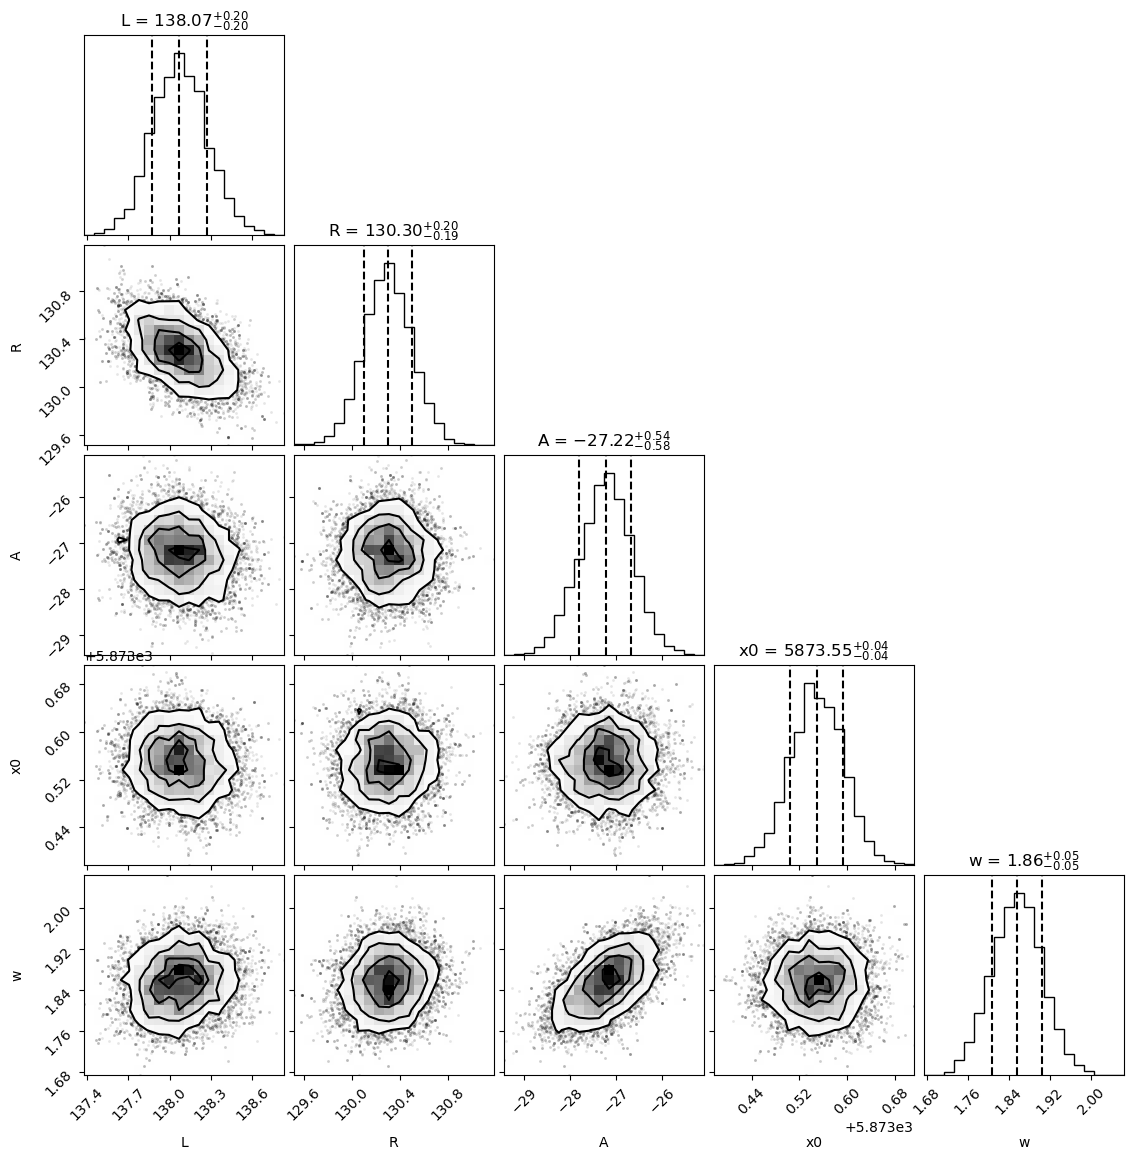

In [7]:
n_burnin = 400

percentage_to_plot = 1.0

converged_chain = sampler.chain[:, n_burnin:, :]
flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84], 
                    labels=param_names, 
                    show_titles=True,
                    range=[percentage_to_plot] * n_dim)

#fig.set_size_inches((10, 8))

## Part F: Best fit value of the parameters

Use the distribution of the parameters to estimate the *best fit values*. What is your statistic of choice?

In [8]:
optimal_parameters = []

for dim in range(n_dim):
    converged_values = sampler.chain[:, n_burnin:, dim].flatten()
    optimal_value = np.median(converged_values)
    print("{} = {:.6g}".format(param_names[dim], optimal_value))
    optimal_parameters.append(np.median(converged_values))

L = 138.071
R = 130.3
A = -27.2172
x0 = 5873.55
w = 1.85614


## Part G: use the best fit values to plot the fitted model along with the data

/tmp/ipykernel_307953/1428286469.py:13: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, residuals, use_line_collection=True)


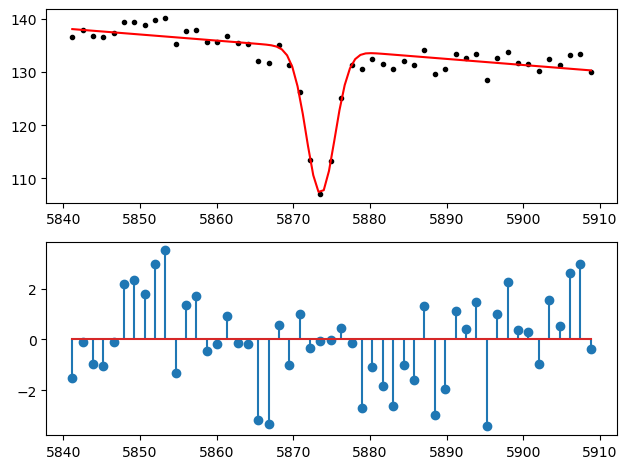

In [9]:
plt.figure()

# plot the data and the fit
plt.subplot(211)
plt.plot(x, y, "k.")
x_model = np.linspace(xmin, xmax, 100)
y_model = model(optimal_parameters, x_model)
plt.plot(x_model, y_model, "r-")

# plot the residuals
plt.subplot(212)
residuals = y - model(optimal_parameters, x)
plt.stem(x, residuals, use_line_collection=True)
plt.tight_layout()
plt.show()

## Question 1

What is the statistic we should use for the best fit parameter value? The mean value, the median, the mode?

## Question 2

Is the contiuum modelled correctly with a line? Could we do better?

## Part F

The SDSS site reports that the redshift of this star is $z = -0.0003$. Can you confirm this?

* the rest frame wavelength of the He I line is $5875.624\ \rm \mathring A$.
* the redshift is computed using the formula:

$$ 1 + z = \frac{\lambda_{\rm obs}}{\lambda_{\rm rest}} $$

In [10]:
He_obs = optimal_parameters[3]
He_true = 5875.624

z = He_obs / He_true - 1
print("Redshift: {:.3g}".format(z))

Redshift: -0.000353


## Question 3

The estimate of the redshift from the He line is not very good. Can you think of way to use the whole spectrum?

# Exercise 2: using a Lorentzian profile

Use the Lorentizan function to model the shape of the absorption line. Remember:

$$ \Large f(x) \propto \frac{1}{1 + \left(\frac{x - x_0}{\gamma}\right)^2} $$

Do the results change significantly?

# Exercise 3: *strict* priors...

The ranges you selected for the parameters might be too narrow or too wide. 

For example, really narrow is... to allow `x0` vary only around the expected position of the absorption line.

On the other hand, really wide is... to use $(-\infty, +\infty)$!

## Question 1: Try to change the parameter ranges to 1000 times larger!

Does the MCMC converge?

## Question 2: Use the original ranges, but not allow $A$ to exceed -30.

Since the fitted value for above, $-30$, how does this constraint translate to our results?

# Extra credit exercise: fit another absorption/emission feature

Use the original data to find another absorption (or even emission) line feature. Then select a window around it. Can you fit it by following all the steps of the 1st exercise? What is the redshift?

# Extra extra credit exercise: directly fitting for $a$ and $b$

## Question: Can you repeat the fitting using, instead of $L$ and $R$, the slope ($a$) and intercept ($b$) for the continuum?

In [11]:
# set the names of the parameters (useful for reporting stuff...)
param_names = ["a", "b", "c", "A", "x0", "w"]

xmin, xmax = min(x), max(x)    # used to convert L and R values to intercept and slope

# set minimum and maximum bounds for the parameters
min_a, max_a = -1000, 1000
min_b, max_b = -1000, 1000
min_c, max_c = -1000, 1000
min_A, max_A = -50.0, -10.0
min_x0, max_x0 = 5860, 5890
min_w, max_w = 0.5, 10.0

def model(theta, x):
    a, b, c, A, x0, w = theta
    return a * x**2.0 + b * x + c + A * np.exp(-(x - x0) ** 2.0 / (2.0 * w ** 2.0))    # Gaussian

def log_prior(theta):
    a, b, c, A, x0, w = theta
    if min_a < a < max_a and min_b < b < max_b and min_c < c < max_c and min_A < A < max_A and min_x0 < x0 < max_x0 and min_w < w < max_w:
        return 0.0
    return -np.inf
    
def log_likelihood(theta, x, y):
    return -np.sum((y - model(theta, x)) ** 2.0)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)


n_walkers = 30
n_dim = 6
n_steps = 1000

# random initial positions for walkers
a_initial = np.random.uniform(min_a, max_a, size=n_walkers)
b_initial = np.random.uniform(min_b, max_b, size=n_walkers)
c_initial = np.random.uniform(min_c, max_c, size=n_walkers)

# use the values from linear regression
# a_initial = a_values
# b_initial = b_values
# c_initial = c_values

A_initial = np.random.uniform(min_A, max_A, size=n_walkers)
x0_initial = np.random.uniform(min_x0, max_x0, size=n_walkers)
w_initial = np.random.uniform(min_w, max_w, size=n_walkers)

# code them in a matrix
p_initial = np.array([a_initial, b_initial, c_initial, A_initial, x0_initial, w_initial]).T

In [12]:
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=log_posterior, args=(x, y))
result = sampler.run_mcmc(p_initial, nsteps=n_steps)

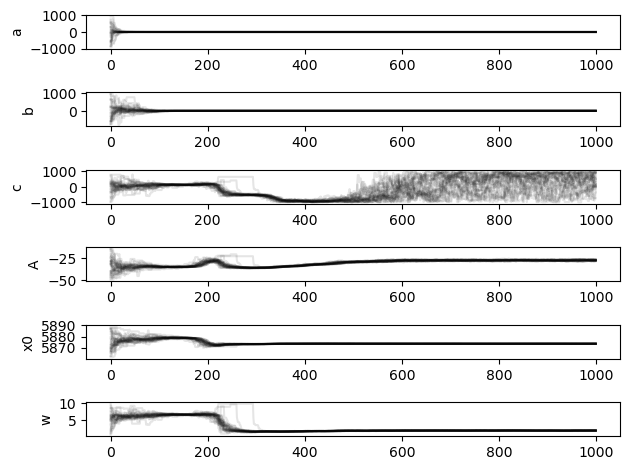

In [13]:
plt.figure()
# for each parameter...
for i in range(n_dim):
    param_name = param_names[i]
    plt.subplot(n_dim, 1, i + 1)
    # ...plot all chains
    for j in range(n_walkers):
        chain = sampler.chain[j, :, i]
        plt.plot(chain, "k-", alpha=0.1)
    plt.ylabel(param_name)
plt.tight_layout()
plt.show()

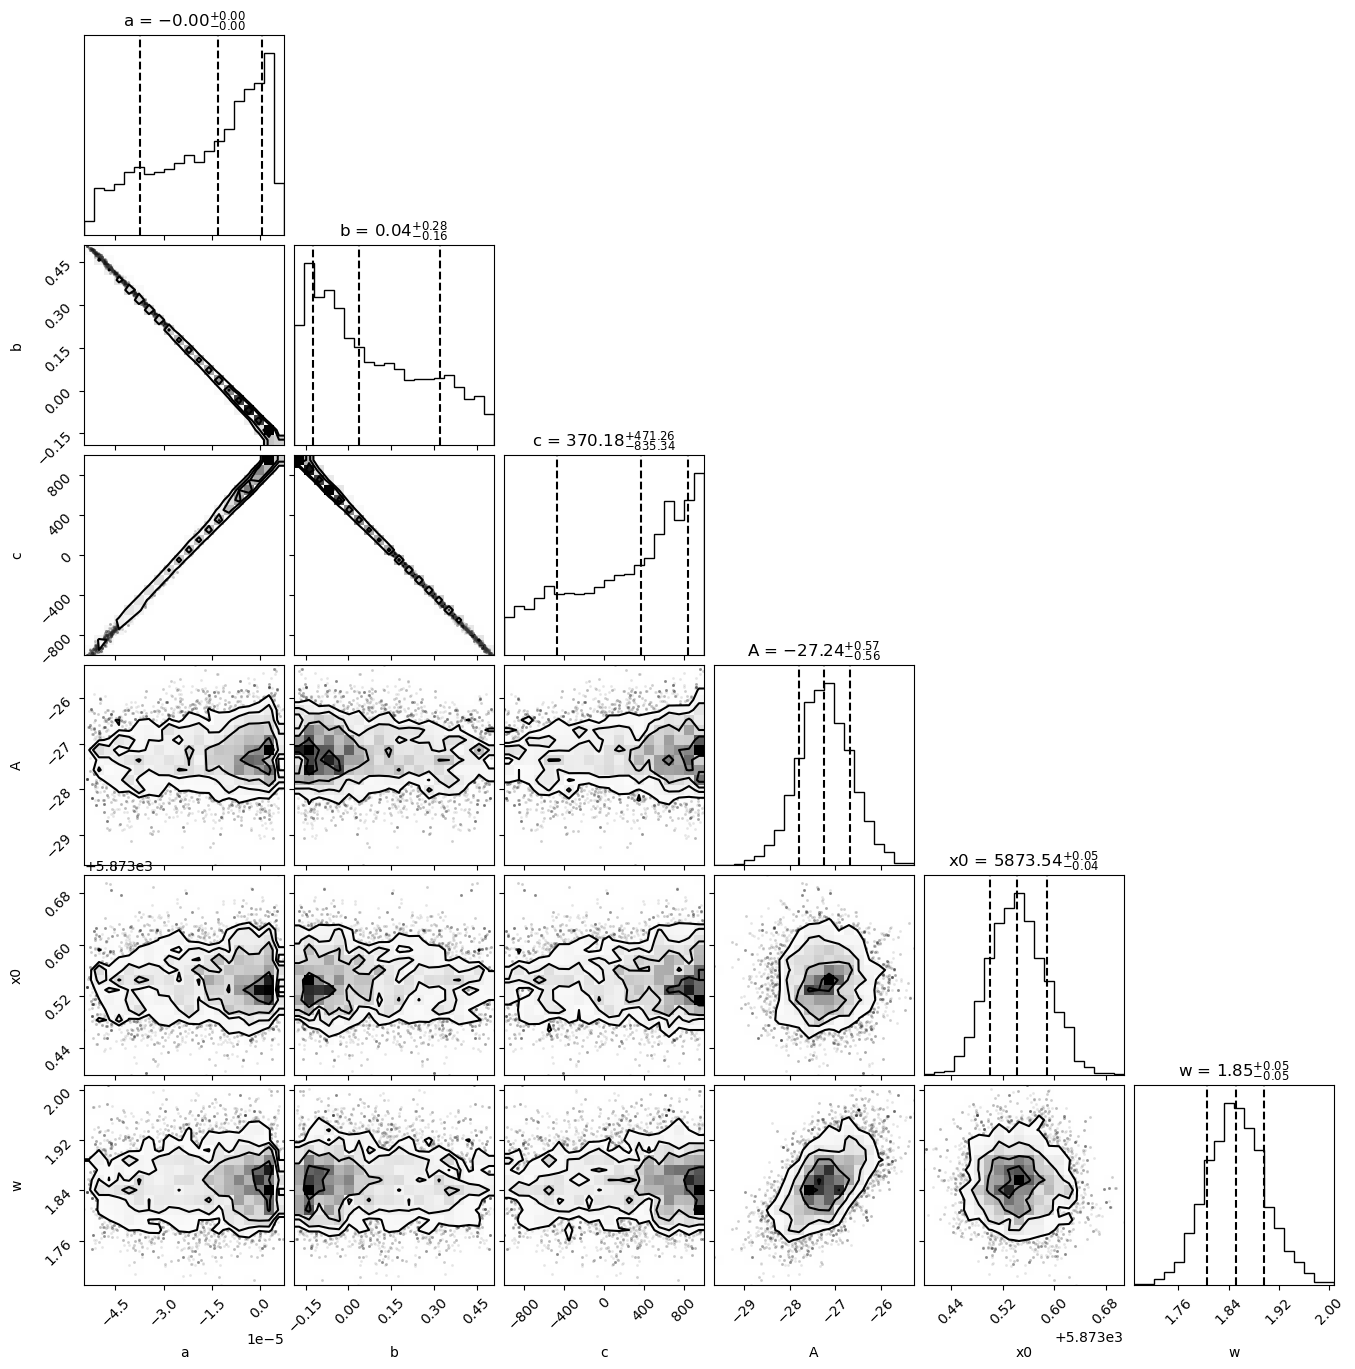

In [14]:
n_burnin = 600

percentage_to_plot = 1.0

converged_chain = sampler.chain[:, n_burnin:, :]
flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84], 
                    labels=param_names, 
                    show_titles=True,
                    range=[percentage_to_plot] * n_dim)

#fig.set_size_inches((10, 8))

a = -1.29925e-05
b = 0.0361146
c = 370.182
A = -27.244
x0 = 5873.54
w = 1.8513


/tmp/ipykernel_307953/2748727731.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, residuals, use_line_collection=True)


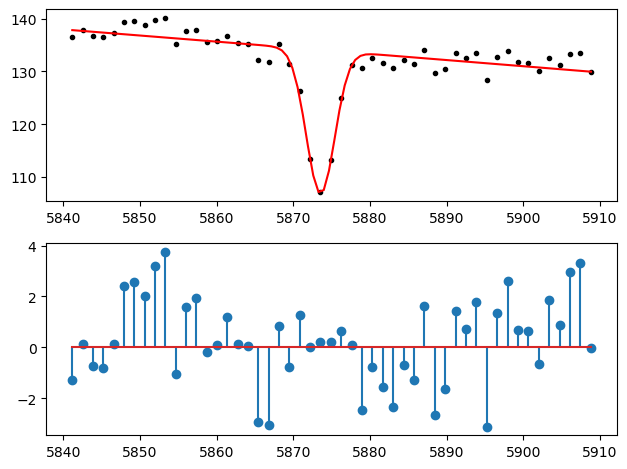

In [15]:
optimal_parameters = []

for dim in range(n_dim):
    converged_values = sampler.chain[:, n_burnin:, dim].flatten()
    optimal_value = np.median(converged_values)
    print("{} = {:.6g}".format(param_names[dim], optimal_value))
    optimal_parameters.append(np.median(converged_values))
    
    
plt.figure()

# plot the data and the fit
plt.subplot(211)
plt.plot(x, y, "k.")
x_model = np.linspace(xmin, xmax, 100)
y_model = model(optimal_parameters, x_model)
plt.plot(x_model, y_model, "r-")

# plot the residuals
plt.subplot(212)
residuals = y - model(optimal_parameters, x)
plt.stem(x, residuals, use_line_collection=True)
plt.tight_layout()
plt.show()

## Question 2: what is the problem above?

When we are using polynomials it might be difficult to set the bound of the parameters. When we were using $L$ and $R$ for the linear fit, we could set the bound easily. If we start with very wide ranges, it might be difficult to focus on the maximum of the posterior.

## Question 3: how can we solve this issue?

Using a simple fitting method to get the best values for the continuum can help us have a better start!

In [16]:
a_fit, b_fit, c_fit = np.polyfit(x, y, deg=2)

print("a = {:.4g}".format(a_fit))
print("b = {:.4g}".format(b_fit))
print("c = {:.4g}".format(c_fit))

a = 0.007281
b = -85.66
c = 2.521e+05


Even better, we can get the initial points for our workers by performing multiple fits! Using different subsamples of our data, we get a "rough" estimate of how much the parameters should vary, at least initially! Let's take random "thirds" of our data and do polynomial fits!

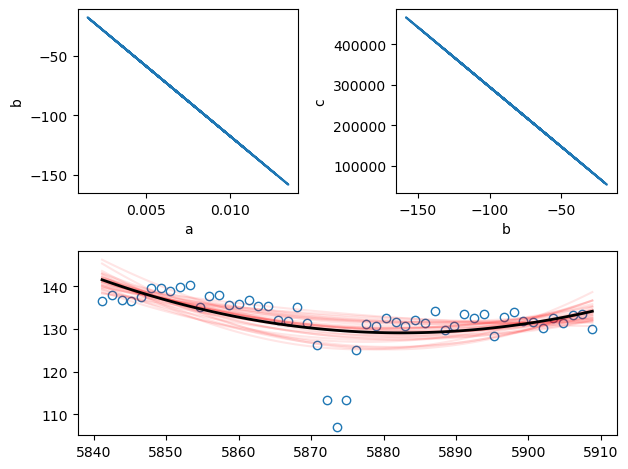

In [17]:
import seaborn

a_values = []
b_values = []
c_values = []

n_subsample = len(x) // 3

for i in range(n_walkers):
    subset_mask = np.random.choice(len(x), size=n_subsample, replace=False)
    x_sub = x[subset_mask]
    y_sub = y[subset_mask]
    a, b, c = np.polyfit(x_sub, y_sub, deg=2)
    a_values.append(a)
    b_values.append(b)
    c_values.append(c)

plt.figure()
plt.subplot(221)
# p = seaborn.jointplot(a_values, b_values)
plt.plot(a_values, b_values)
# p.set_axis_labels("a", "b")
plt.xlabel("a")
plt.ylabel("b")

plt.subplot(222)
plt.plot(b_values, c_values)
plt.xlabel("b")
plt.ylabel("c")

plt.subplot(212)
plt.plot(x, y, "o", mfc="none")
xx = np.linspace(min(x), max(x), 100)
for a, b, c in zip(a_values, b_values, c_values):
    yy = a * xx**2.0 + b * xx + c
    plt.plot(xx, yy, "r-", alpha=0.1)
plt.plot(xx, a_fit * xx**2.0 + b_fit * xx + c_fit, "k-", lw=2) 

plt.tight_layout()
plt.show()

## Now we can use these values as initial positions of our walkers!